In [ ]:
!pip install -q causal-learn graphviz networkx econml tfcausalimpact # pygraphviz pyvis
!pip install git+https://github.com/py-why/dowhy@main
!apt-get install graphviz libgraphviz-dev -y
!pip install pygraphviz

In [1]:
import dowhy
from dowhy import CausalModel

import numpy as np
import pandas as pd
import graphviz
import networkx as nx
import seaborn as sns
import matplotlib.pyplot as plt

np.set_printoptions(precision=4, suppress=True)
from google.colab import drive
drive.mount('/content/drive')
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

Mounted at /content/drive


In [26]:
# step 0 load data
file_path = '/content/drive/My Drive/Colab Notebooks/churn.csv'
data = pd.read_csv(file_path)
data = data.drop(columns=["RowNumber", "Surname", "CustomerId"])
# data = pd.get_dummies(data, columns=["Geography", "Gender"], drop_first=True)
from sklearn.preprocessing import LabelEncoder

data["Geography"] = LabelEncoder().fit_transform(data["Geography"])
data["Gender"] = LabelEncoder().fit_transform(data["Gender"])
data.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,0,0,42,2,0.00,1,1,1,101348.88,1
1,608,2,0,41,1,83807.86,1,0,1,112542.58,0
2,502,0,0,42,8,159660.80,3,1,0,113931.57,1
3,699,0,0,39,1,0.00,2,0,0,93826.63,0
4,850,2,0,43,2,125510.82,1,1,1,79084.10,0


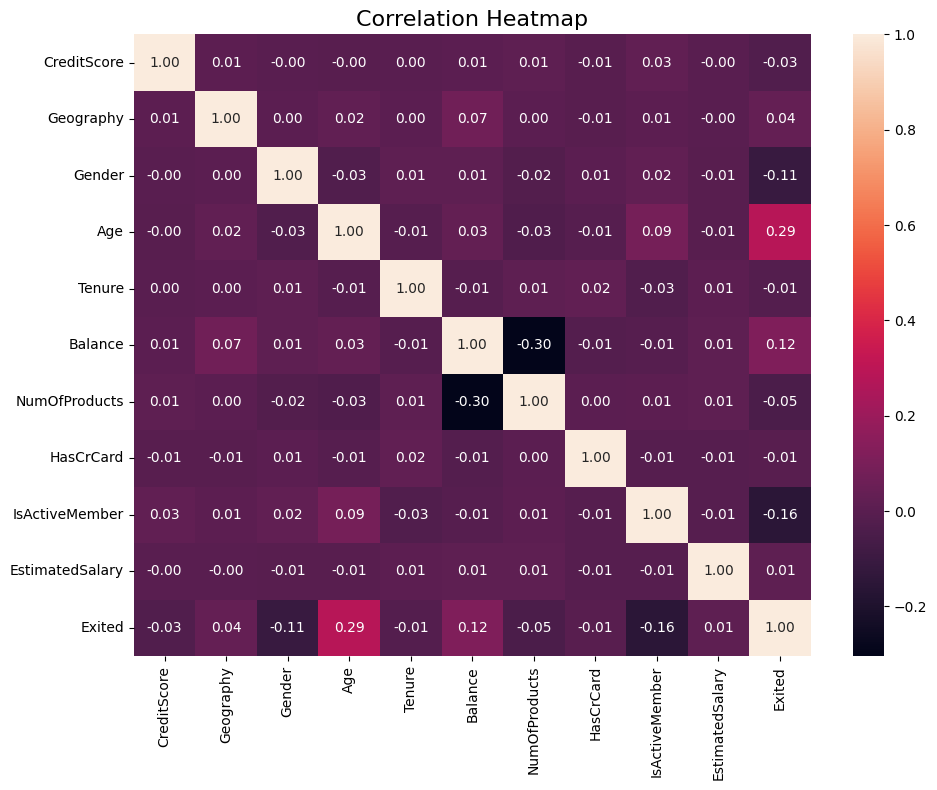

In [27]:
plt.figure(figsize=(10, 8))
sns.heatmap(data.corr(), annot=True, fmt=".2f")
plt.title("Correlation Heatmap", fontsize=16)
plt.tight_layout()
plt.show()

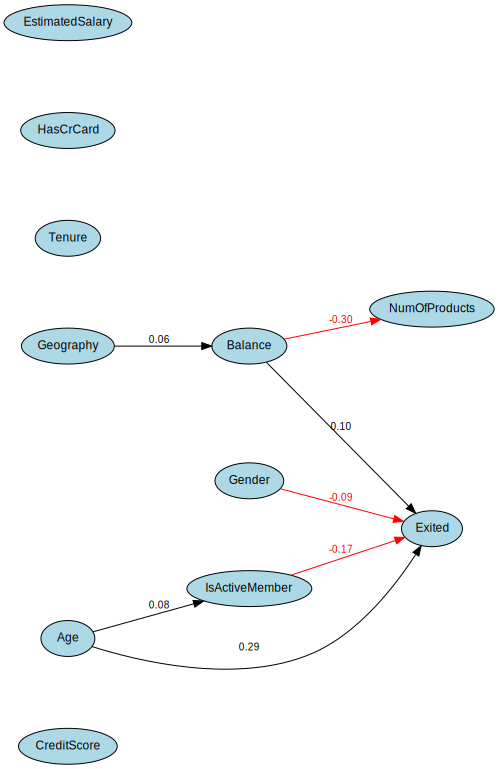

In [28]:
# Step 1: LiNGAM causal discovery
from causallearn.search.FCMBased import lingam
model_lingam = lingam.ICALiNGAM()

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
data_scaled = pd.DataFrame(scaler.fit_transform(data), columns=data.columns)

model_lingam.fit(data_scaled.values)
B_hat = model_lingam.adjacency_matrix_

labels = data.columns.tolist()

from graphviz import Source

def pretty_make_dot(adj_matrix, labels):
    dot = ["digraph G {"]
    dot.append('    graph [rankdir=LR, splines=true, overlap=false, nodesep=1.0];')
    dot.append('    node [shape=ellipse, style=filled, fillcolor=lightblue, fontsize=12, fontname=Helvetica];')
    dot.append('    edge [fontsize=10, fontcolor=gray20, fontname=Helvetica];')

    d = adj_matrix.shape[0]
    for i in range(d):
        dot.append(f'    "{labels[i]}" [label="{labels[i]}"];')

    for i in range(d):
        for j in range(d):
            w = adj_matrix[i, j]
            if abs(w) > 1e-8:
                color = "black" if w > 0 else "red"
                dot.append(
                    f'    "{labels[i]}" -> "{labels[j]}" [label="{w:.2f}", color="{color}", fontcolor="{color}"];'
                )

    dot.append("}")
    return Source("\n".join(dot))

pretty_make_dot(B_hat.T, labels)

In [29]:
def str_to_dot(string):
    '''
    Converts input string from graphviz library to valid DOT graph format.
    '''
    graph = string.strip().replace('\n', ';').replace('\t','')
    graph = graph[:9] + graph[10:-2] + graph[-1] # Removing unnecessary characters from string
    return graph

def make_graph(adjacency_matrix, labels=None):
    idx = np.abs(adjacency_matrix) > 0.01
    dirs = np.where(idx)
    d = graphviz.Digraph(engine='dot')
    names = labels if labels else [f'x{i}' for i in range(len(adjacency_matrix))]
    for name in names:
        d.node(name)
    for to, from_, coef in zip(dirs[0], dirs[1], adjacency_matrix[idx]):
        d.edge(names[from_], names[to], label=str(coef))
    return d

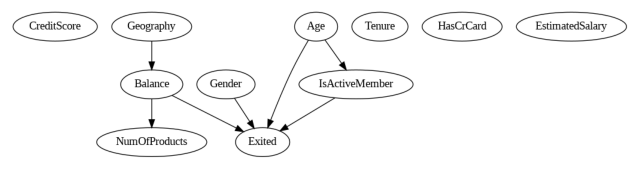

In [31]:
# Step 3: Create DoWhy CausalModel
graph_dot = make_graph(B_hat, labels=labels)
model = CausalModel(
    data=data,
    treatment="IsActiveMember",
    outcome="Exited",
    graph=str_to_dot(graph_dot.source)
)
model.view_model()

In [32]:
# Step 3b: Identify causal effect
identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)

# pretty print
from IPython.display import Markdown, display

def format_estimand_output(identified_estimand):
    if isinstance(identified_estimand, str):
        display(Markdown("❌ **Error:** This is a string, not an estimand object."))
        return

    display(Markdown(f"### 🎯 Estimand type: `{identified_estimand.estimand_type}`"))
    display(Markdown(f"- **Treatment**: `{identified_estimand.treatment_variable}`"))
    display(Markdown(f"- **Outcome**: `{identified_estimand.outcome_variable}`"))

    for name, est in identified_estimand.estimands.items():
        block = f"#### 🔹 Estimand: `{name}`\n"

        # Skip if est is None
        if est is None:
            block += "- ⚠️ Not available (no valid variables found).\n"
            display(Markdown(block))
            continue

        # Expression
        expr = est.get("estimand", None)
        block += f"- **Expression**: `{expr}`\n" if expr else "- **Expression**: *Not available*\n"

        # Adjustment set
        if "adjustment_set" in est:
            block += f"- **Adjustment set**: `{est['adjustment_set']}`\n"

        # Assumptions
        assumptions = est.get("assumptions", {})
        if assumptions:
            block += "- **Assumptions:**\n"
            for k, v in assumptions.items():
                block += f"  - {k}: {v}\n"
        else:
            block += "- *No assumptions.*\n"

        display(Markdown(block))

# Step 3: display
format_estimand_output(identified_estimand)

### 🎯 Estimand type: `EstimandType.NONPARAMETRIC_ATE`

- **Treatment**: `['IsActiveMember']`

- **Outcome**: `['Exited']`

#### 🔹 Estimand: `backdoor1`
- **Expression**: `Derivative(Expectation(Exited|Geography,Gender,NumOfProducts,Age,Balance), [IsActiveMember])`
- **Assumptions:**
  - Unconfoundedness: If U→{IsActiveMember} and U→Exited then P(Exited|IsActiveMember,Geography,Gender,NumOfProducts,Age,Balance,U) = P(Exited|IsActiveMember,Geography,Gender,NumOfProducts,Age,Balance)


#### 🔹 Estimand: `backdoor2`
- **Expression**: `Derivative(Expectation(Exited|Age), [IsActiveMember])`
- **Assumptions:**
  - Unconfoundedness: If U→{IsActiveMember} and U→Exited then P(Exited|IsActiveMember,Age,U) = P(Exited|IsActiveMember,Age)


#### 🔹 Estimand: `backdoor`
- **Expression**: `Derivative(Expectation(Exited|Age), [IsActiveMember])`
- **Assumptions:**
  - Unconfoundedness: If U→{IsActiveMember} and U→Exited then P(Exited|IsActiveMember,Age,U) = P(Exited|IsActiveMember,Age)


#### 🔹 Estimand: `iv`
- ⚠️ Not available (no valid variables found).


#### 🔹 Estimand: `frontdoor`
- ⚠️ Not available (no valid variables found).


#### 🔹 Estimand: `general1`
- **Expression**: `Derivative(Expectation(Exited|Age), [IsActiveMember])`
- **Assumptions:**
  - Unconfoundedness: If U→{IsActiveMember} and U→Exited then P(Exited|IsActiveMember,Age,U) = P(Exited|IsActiveMember,Age)


#### 🔹 Estimand: `general_adjustment`
- **Expression**: `Derivative(Expectation(Exited|Age), [IsActiveMember])`
- **Assumptions:**
  - Unconfoundedness: If U→{IsActiveMember} and U→Exited then P(Exited|IsActiveMember,Age,U) = P(Exited|IsActiveMember,Age)


In [33]:
# Step 4: Estimate ATE using linear regression adjustment
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

estimate = model.estimate_effect(
    identified_estimand,
    method_name="backdoor.linear_regression",
    confidence_intervals=True,
    test_significance=True# ,
    # method_params={"use_interactions": False}
)

from IPython.display import Markdown, display

def summarize_estimate_output(estimate):
    lines = []
    lines.append("### 📊 **Estimated Average Treatment Effect (ATE)**")

    # Point estimate
    lines.append(f"- **ATE value**: `{estimate.value:.4f}`")

    # Confidence Interval
    ci_low, ci_high = estimate.get_confidence_intervals()
    lines.append(f"- **95% CI**: `({ci_low:.4f}, {ci_high:.4f})`")

    # P-value
    pval = estimate.test_stat_significance()["p_value"]
    lines.append(f"- **p-value**: `{pval[0]:.4f}` {'✅ Significant' if pval[0] < 0.05 else '⚠️ Not significant'}")

    # Model formula
    lines.append("### 🧮 **Regression Formula:**")
    lines.append(f"`{estimate.realized_estimand_expr}`")

    # Conditional effect table (optional preview)
    lines.append("\n### 🧩 **Top 5 Conditional Estimates (by subgroup):**")
    try:
        df = estimate.conditional_estimates
        display(Markdown("\n".join(lines)))
        display(df.head())  # show top 5 CATEs
    except Exception:
        lines.append("*No conditional subgroup effects available.*")
        display(Markdown("\n".join(lines)))

summarize_estimate_output(estimate)

### 📊 **Estimated Average Treatment Effect (ATE)**
- **ATE value**: `-0.1454`
- **95% CI**: `(-0.1579, -0.1296)`
- **p-value**: `0.0000` ✅ Significant
### 🧮 **Regression Formula:**
`b: Exited~IsActiveMember+Age+IsActiveMember*Geography+IsActiveMember*Gender+IsActiveMember*Balance`

### 🧩 **Top 5 Conditional Estimates (by subgroup):**

__categorical__Geography  __categorical__Gender  __categorical__Balance  
(-0.001, 1.0]             (-0.001, 1.0]          (-0.001, 73080.908]        -0.185837
                                                 (73080.908, 110138.926]    -0.133314
                                                 (110138.926, 133710.358]   -0.120246
                                                 (133710.358, 250898.09]    -0.103168
(1.0, 2.0]                (-0.001, 1.0]          (-0.001, 73080.908]        -0.184518
dtype: float64

In [ ]:
from sklearn.linear_model import LassoCV, LogisticRegressionCV
from econml.dml import LinearDML

estimate_cate = model.estimate_effect(
    identified_estimand,
    method_name="backdoor.econml.dml.LinearDML",
    confidence_intervals=False,
    test_significance=False,
    method_params={
        "init_params": {
            "model_y": LassoCV(cv=3),
            "model_t": LogisticRegressionCV(cv=3, max_iter=1000),
            "discrete_treatment": True,
            "random_state": 0
        },
        "fit_params": {},
        "need_conditional_estimates": True
    }
)

# Individual-level ITE
ite = estimate_cate.estimator.effect(data)

# 2-D scatter (Age vs Balance, color = ITE)
def plot_heterogeneity_by_columns(data, ite, col_x, col_y):
    x = data[col_x]
    y = data[col_y]

    x_median = x.median()
    y_median = y.median()
    plt.figure(figsize=(7, 6))
    sc = plt.scatter(x, y, c=ite, cmap="viridis", s=25)
    plt.axvline(x=x_median, color='red', linestyle='--', linewidth=2)
    plt.axhline(y=y_median, color='red', linestyle='--', linewidth=2)
    plt.colorbar(sc, label="Effect Size")
    plt.xlabel(col_x)
    plt.ylabel(col_y)
    plt.title("Causal Responder Detection by Heterogeneity")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_heterogeneity_by_columns(data, ite, col_x="Age", col_y="Balance")


In [57]:
def plot_cate_boxplot(
    data,
    ite,
    group_col,
    title=None,
    xlabel=None,
    ylabel="Estimated Effect",
    bins=None,
    label_map=None,
    agg_func='mean',  # or 'median'
    show_points=True,
    point_alpha=0.3,
    point_size=20,
):
    """
    Plot a grouped boxplot with optional overlay of individual treatment effects (ITE).

    Parameters:
        data: pd.DataFrame
            Original dataset.
        ite: array-like
            Estimated individual treatment effects.
        group_col: str
            Column to group by.
        title: str
            Plot title.
        xlabel: str
            X-axis label.
        ylabel: str
            Y-axis label.
        bins: list, optional
            Bin edges if group_col is numeric.
        label_map: dict, optional
            Mapping for label decoding (e.g., Geography).
        agg_func: str
            'mean' or 'median' for annotation and sorting.
        show_points: bool
            Whether to show individual ITE dots.
        point_alpha: float
            Transparency level of points (0 to 1).
        point_size: int
            Size of the ITE scatter dots.
    """

    df = data.copy()
    df["ITE"] = ite

    # Bin numeric variable if needed (e.g., Age)
    if bins is not None:
        df[group_col] = pd.cut(df[group_col], bins=bins)

    # Apply label mapping if provided (e.g., decode region)
    if label_map is not None:
        df[group_col] = df[group_col].map(label_map)

    # Compute group-level aggregation for sorting
    grouped = df.groupby(group_col)["ITE"].agg(agg_func).sort_values()
    ordered_groups = grouped.index.tolist()

    # Set color palette
    palette = sns.color_palette("Set2", len(ordered_groups))

    # Plot boxplot
    plt.figure(figsize=(10, 6))
    ax = sns.boxplot(
        x=group_col, y="ITE", data=df,
        order=ordered_groups, palette=palette,
        showfliers=False  # Hide outliers since we show points
    )

    # Overlay individual ITE points
    if show_points:
        sns.stripplot(
            x=group_col, y="ITE", data=df,
            order=ordered_groups, color="black", alpha=point_alpha,
            size=point_size/10, jitter=0.25
        )

    # Add group average/median annotations
    for i, group in enumerate(ordered_groups):
        val = grouped.loc[group]
        ax.text(i, val, f'{val:.3f}', ha='center', va='bottom', fontsize=15, color='red')

    # Configure plot
    plt.title(title if title else f"Treatment Effect by {group_col}")
    plt.xlabel(xlabel if xlabel else group_col)
    plt.ylabel(ylabel)
    plt.grid(True, axis='y')
    plt.tight_layout()
    plt.show()


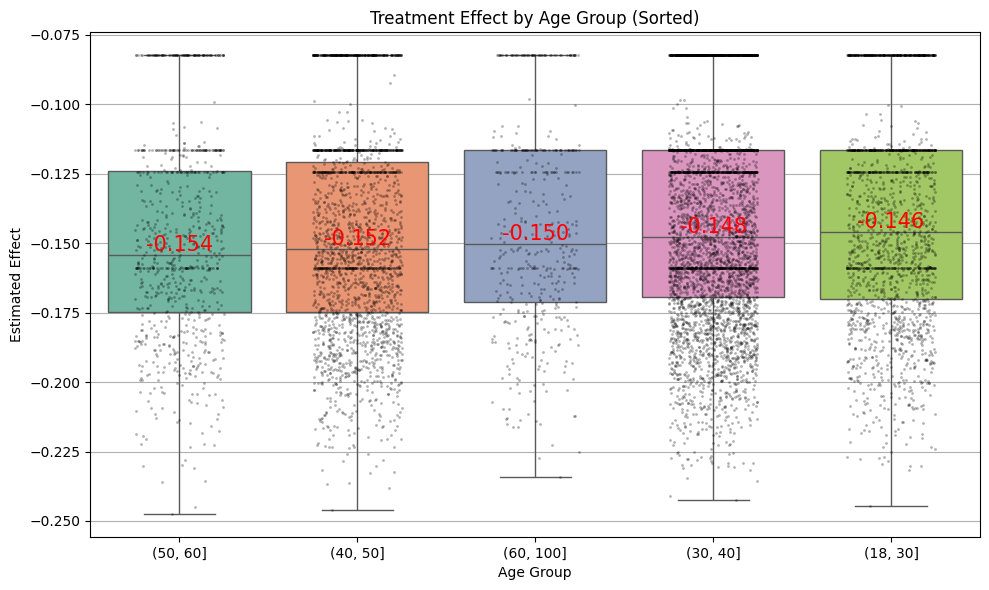

In [58]:
plot_cate_boxplot(
    data=data,
    ite=ite,
    group_col="Age",
    bins=[18, 30, 40, 50, 60, 100],
    title="Treatment Effect by Age Group (Sorted)",
    xlabel="Age Group",
    agg_func="median"
)


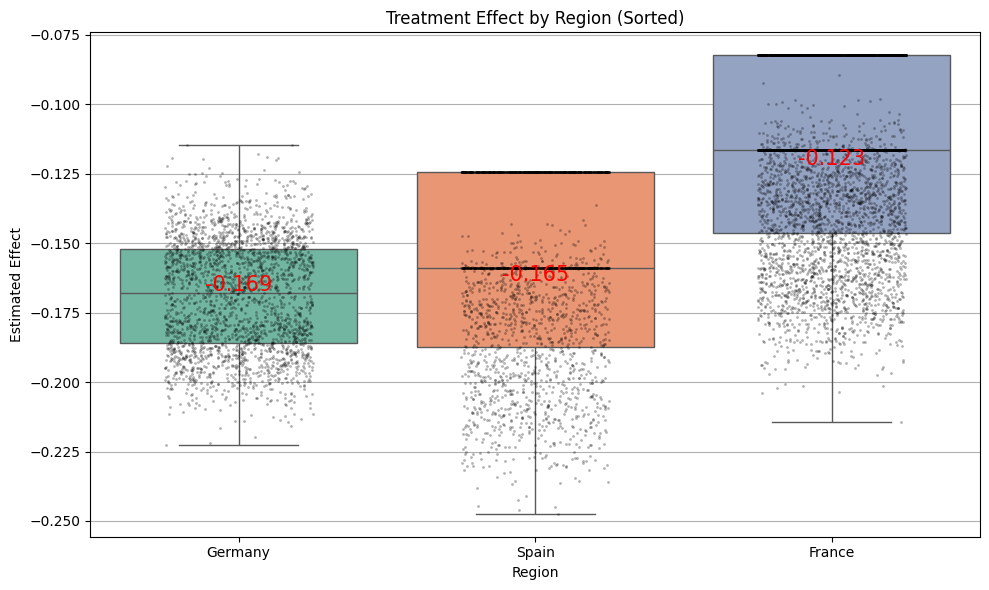

In [59]:
region_map = {0: "France", 1: "Germany", 2: "Spain"}

plot_cate_boxplot(
    data=data,
    ite=ite,
    group_col="Geography",
    title="Treatment Effect by Region (Sorted)",
    xlabel="Region",
    label_map=region_map,
    agg_func="mean"
)



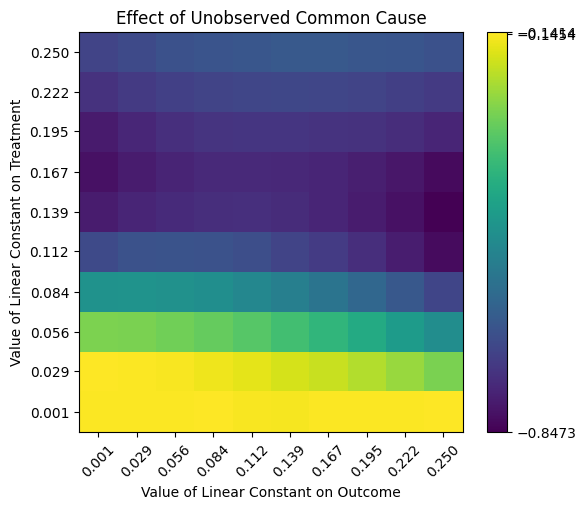

### 🧪 Refutation: Unobserved Common Cause
- **Original ATE estimate**: `-0.1454`
- **New effect range (under simulated confounding)**: `(-0.8473, -0.1414)`
- **Interpretation**: ⚠️ *ATE might be sensitive* to potential hidden confounders.

---
This analysis simulates the presence of an **unobserved confounder** affecting both treatment and outcome.
It varies the strength of this confounder and recomputes the treatment effect.
If the estimated ATE remains stable across these simulations, we consider it **robust**.
The heatmap above visualizes how treatment effect changes as the unobserved confounder gets stronger.

In [72]:
res = model.refute_estimate(
    identified_estimand,
    estimate,
    method_name="add_unobserved_common_cause",
    confounders_effect_on_treatment="linear",
    confounders_effect_on_outcome="linear",
    effect_strength_on_treatment= np.round(np.linspace(0.001, 0.25, 10), 3),
    effect_strength_on_outcome=np.round(np.linspace(0.001, 0.25, 10), 3),
    plot=True
)

def summarize_unobserved_confounder_refutation(refutation_result):
    original_ate = float(refutation_result.estimated_effect)
    new_min = float(refutation_result.new_effect[0])
    new_max = float(refutation_result.new_effect[1])

    lines = []
    lines.append("### 🧪 Refutation: Unobserved Common Cause")
    lines.append(f"- **Original ATE estimate**: `{original_ate:.4f}`")
    lines.append(f"- **New effect range (under simulated confounding)**: `({new_min:.4f}, {new_max:.4f})`")
    lines.append(f"- **Max deviation from original**: `{delta:.4f}`")

    # Basic sensitivity flag
    significant_change = abs(original_ate - new_min) > 0.1 or abs(original_ate - new_max) > 0.1
    lines.append(f"- **Interpretation**: {'⚠️ *ATE might be sensitive*' if significant_change else '✅ *ATE is relatively robust*'} to potential hidden confounders.")

    lines.append("\n---")
    lines.append("This analysis simulates the presence of an **unobserved confounder** affecting both treatment and outcome.")
    lines.append("It varies the strength of this confounder and recomputes the treatment effect.")
    lines.append("If the estimated ATE remains stable across these simulations, we consider it **robust**.")
    lines.append("The heatmap above visualizes how treatment effect changes as the unobserved confounder gets stronger.")

    display(Markdown("\n".join(lines)))

summarize_unobserved_confounder_refutation(res)


In [ ]:
def plot_sensitivity_distributions(model, identified_estimand, estimate, n_sim=300):
    """
    Perform repeated simulations of different refuter methods and visualize the sensitivity
    of causal estimates using histogram and KDE plots.

    Parameters:
    - model: The DoWhy CausalModel object
    - identified_estimand: The identified causal estimand
    - estimate: The estimated effect from model.estimate_effect
    - n_sim: Number of refutation simulations to run per method

    Outputs:
    - Displays three side-by-side sensitivity plots for:
        1. Random Common Cause
        2. Data Subset Refuter
        3. Placebo Treatment Refuter
    """

    # Storage for refuted effects
    effects_random = []
    effects_subset = []
    effects_placebo = []

    # Random Common Cause
    for _ in range(n_sim):
        ref = model.refute_estimate(
            identified_estimand,
            estimate,
            method_name="random_common_cause",
            num_simulations=1
        )
        effects_random.append(ref.new_effect)

    # Data Subset Refuter
    for _ in range(n_sim):
        ref = model.refute_estimate(
            identified_estimand,
            estimate,
            method_name="data_subset_refuter",
            subset_fraction=0.8,
            num_simulations=1
        )
        effects_subset.append(ref.new_effect)

    # Placebo Treatment Refuter
    for _ in range(n_sim):
        ref = model.refute_estimate(
            identified_estimand,
            estimate,
            method_name="placebo_treatment_refuter",
            num_simulations=1
        )
        effects_placebo.append(ref.new_effect)

    # Convert to numpy arrays
    effects_random = np.array(effects_random)
    effects_subset = np.array(effects_subset)
    effects_placebo = np.array(effects_placebo)

    # Plotting
    fig, axs = plt.subplots(1, 3, figsize=(18, 5), sharey=True)

    # 1. Random Common Cause
    sns.histplot(effects_random, kde=True, color="skyblue", ax=axs[0], bins=25)
    axs[0].axvline(estimate.value, color="red", linestyle="--", label="Original Estimate")
    axs[0].axvline(np.mean(effects_random), color="green", linestyle="-", label="Mean Refuted")
    axs[0].set_title("Random Common Cause Refuter")
    axs[0].set_xlabel("Estimated Effect")
    axs[0].legend()

    # 2. Data Subset Refuter
    sns.histplot(effects_subset, kde=True, color="orange", ax=axs[1], bins=25)
    axs[1].axvline(estimate.value, color="red", linestyle="--", label="Original Estimate")
    axs[1].axvline(np.mean(effects_subset), color="green", linestyle="-", label="Mean Refuted")
    axs[1].set_title("Data Subset Refuter")
    axs[1].set_xlabel("Estimated Effect")
    axs[1].legend()

    # 3. Placebo Treatment Refuter
    sns.histplot(effects_placebo, kde=True, color="lightgreen", ax=axs[2], bins=25)
    axs[2].axvline(estimate.value, color="red", linestyle="--", label="Original Estimate")
    axs[2].axvline(np.mean(effects_placebo), color="orange", linestyle="-", label="Mean Refuted")
    axs[2].set_title("Placebo Treatment Refuter")
    axs[2].set_xlabel("Estimated Effect")
    axs[2].legend()

    plt.tight_layout()
    plt.show()

plot_sensitivity_distributions(model, identified_estimand, estimate, n_sim=300)

## Time-series Data

Instructions for updating:
Please use `StructuralTimeSeries.joint_distribution(observed_time_series).log_prob`
Instructions for updating:
`Predictive distributions returned by`tfp.sts.one_step_predictive` will soon compute per-timestep probabilities (treating timesteps as part of the batch shape) instead of a single probability for an entire series (the current approach, in which timesteps are treated as event shape). Please update your code to pass `timesteps_are_event_shape=False` (this will soon be the default) and to explicitly sum over the per-timestep log probabilities if this is required.


Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    125.23             3756.86
Prediction (s.d.)         120.38 (0.3)       3611.44 (8.97)
95% CI                    [119.79, 120.97]   [3593.8, 3628.96]

Absolute effect (s.d.)    4.85 (0.3)         145.42 (8.97)
95% CI                    [4.26, 5.44]       [127.91, 163.07]

Relative effect (s.d.)    4.03% (0.25%)      4.03% (0.25%)
95% CI                    [3.54%, 4.52%]     [3.54%, 4.52%]

Posterior tail-area probability p: 0.0
Posterior prob. of a causal effect: 100.0%

For more details run the command: print(impact.summary('report'))
Analysis report {CausalImpact}


During the post-intervention period, the response variable had
an average value of approx. 125.23. By contrast, in the absence of an
intervention, we would have expected an average response of 120.38.
The 95% interval of this counterfactual prediction is [119.79, 120.97].
Subtracting this prediction from t

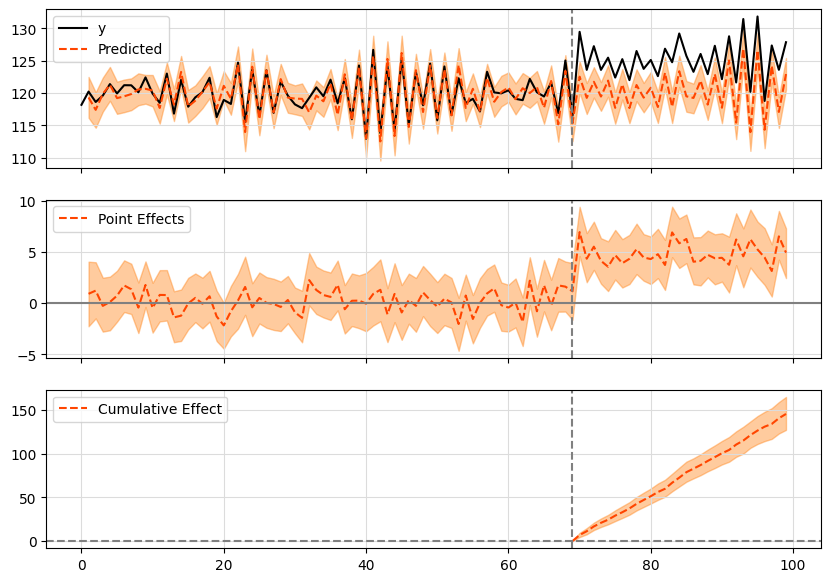

In [73]:
from causalimpact import CausalImpact


data = pd.read_csv('https://raw.githubusercontent.com/WillianFuks/tfcausalimpact/master/tests/fixtures/arma_data.csv')[['y', 'X']]
data.iloc[70:, 0] += 5

pre_period = [0, 69]
post_period = [70, 99]

ci = CausalImpact(data, pre_period, post_period)
print(ci.summary())
print(ci.summary(output='report'))
ci.plot()